# Modelo de reconhecimento de objetos

O modelo basicamente consiste no fine-tuning de um modelo InceptionV3 em cima de um dataset scrappado com aproximadamente 100 imagens de: Fones de ouvido, Impressoras e Roteadores.



**Time “Zin” (#29)**
- Abelardo Borges Fukasawa (Data Engineer)
- Lucas Hideki Ueda (Data Scientist)
- Victor Wildner (Data Analyst)
- Vivian Estequi (Business Analyst)
- Wesley Rischioni (Colaborador Santander)

In [1]:
import numpy as np
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [55]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [5]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
    validation_split=0.2) 

In [6]:
train_path = '/content/drive/My Drive/DATATHON_SANTANDER_2020/images'

In [7]:
batchSize=32


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batchSize,
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batchSize,
    subset='validation') 

Found 334 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


In [12]:
#InceptionV3

base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
# base_model.trainable = False # O melhor modelo se deu re treinando todos os pesos
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(3, activation='softmax')(x) # 3 classes, uma para cada item

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


In [13]:
modelName= "/content/drive/My Drive/DATATHON_SANTANDER_2020/Icepbase"

filepath=modelName+"_bestweights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs = 10,
    # steps_per_epoch = stepsPerEpoch,
    # validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=True)

Epoch 1/10
11/11 [==============================] - 12s 1s/step - loss: 0.4786 - accuracy: 0.8084 - val_loss: 1.0029 - val_accuracy: 0.5926
Epoch 2/10
11/11 [==============================] - 10s 937ms/step - loss: 0.1135 - accuracy: 0.9521 - val_loss: 0.4335 - val_accuracy: 0.8395
Epoch 3/10
11/11 [==============================] - 11s 990ms/step - loss: 0.0340 - accuracy: 0.9970 - val_loss: 0.3129 - val_accuracy: 0.8642
Epoch 4/10
11/11 [==============================] - 10s 938ms/step - loss: 0.0148 - accuracy: 0.9970 - val_loss: 0.1229 - val_accuracy: 0.9877
Epoch 5/10
11/11 [==============================] - 10s 950ms/step - loss: 0.0313 - accuracy: 0.9910 - val_loss: 0.1299 - val_accuracy: 0.9630
Epoch 6/10
11/11 [==============================] - 10s 943ms/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.1015 - val_accuracy: 0.9630
Epoch 7/10
11/11 [==============================] - 11s 969ms/step - loss: 0.0138 - accuracy: 0.9940 - val_loss: 0.0712 - val_accuracy: 0.9877
Ep

In [56]:
#  Imagens de teste extraídas do google, nunca vistas nem no treinamento nem na validação
impressora, x_imp = get_image('/content/drive/My Drive/DATATHON_SANTANDER_2020/impressora.jpg')
roteador, x_rot = get_image('/content/drive/My Drive/DATATHON_SANTANDER_2020/roteador.jpg')
fone, x_fone = get_image('/content/drive/My Drive/DATATHON_SANTANDER_2020/fone.jpg')

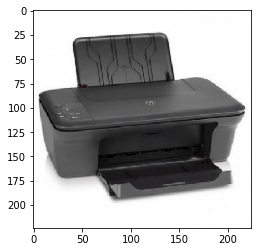

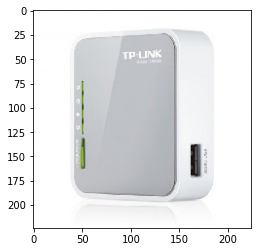

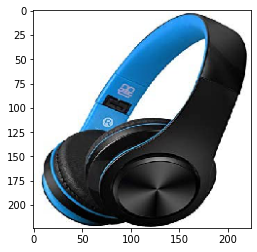

In [57]:
plt.imshow(impressora)
plt.show()
plt.imshow(roteador)
plt.show()
plt.imshow(fone)

In [58]:
# Encode feito pelo próprio generator
train_generator.class_indices

{'fone_de_ouvido': 0, 'impressora': 1, 'roteador': 2}

In [59]:
# Mapping do label para a classe
map_label = {0 : 'Fone de ouvido', 1: 'Impressora', 2: 'Roteador'}

In [60]:
map_label[np.argmax(model.predict(x_imp))]

'Impressora'

In [61]:
map_label[np.argmax(model.predict(x_rot))]

'Roteador'

In [62]:
map_label[np.argmax(model.predict(x_fone))]

'Fone de ouvido'

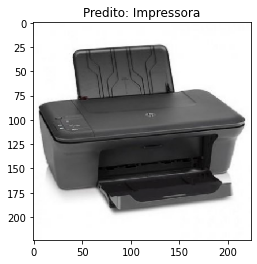

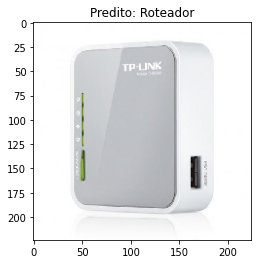

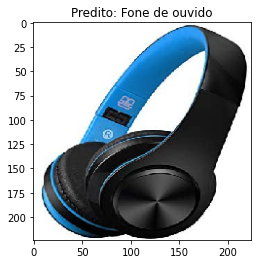

In [63]:
plt.title(f'Predito: {map_label[np.argmax(model.predict(x_imp))]}')
plt.imshow(impressora)
plt.show()
plt.title(f'Predito: {map_label[np.argmax(model.predict(x_rot))]}')
plt.imshow(roteador)
plt.show()
plt.title(f'Predito: {map_label[np.argmax(model.predict(x_fone))]}')
plt.imshow(fone)

In [68]:
# Salvando modelo
model_json = model.to_json()
with open("/content/drive/My Drive/DATATHON_SANTANDER_2020/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/DATATHON_SANTANDER_2020/model.h5")

In [69]:
# Testando dando load no modelo
json_file = open('/content/drive/My Drive/DATATHON_SANTANDER_2020/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/DATATHON_SANTANDER_2020/model.h5")

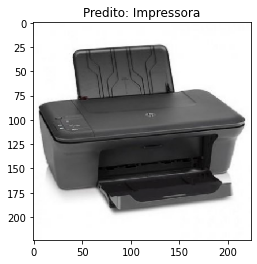

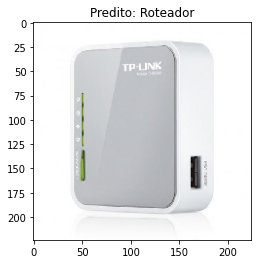

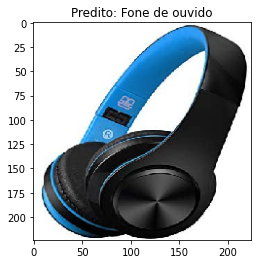

In [67]:
plt.title(f'Predito: {map_label[np.argmax(loaded_model.predict(x_imp))]}')
plt.imshow(impressora)
plt.show()
plt.title(f'Predito: {map_label[np.argmax(loaded_model.predict(x_rot))]}')
plt.imshow(roteador)
plt.show()
plt.title(f'Predito: {map_label[np.argmax(loaded_model.predict(x_fone))]}')
plt.imshow(fone)